In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

%matplotlib inline

Collect the data and ready it for use.

Also check what's in the data as well so as to plan ahead for preprocessing steps.  

In [3]:

# -------------------- DSII -------------------- #


def load_data(file_name_list):
    master_df = pd.read_csv(file_name_list[0],nrows=60110)
    for files in file_name_list[1:]:
        df = pd.read_csv(files, nrows=60110)
        master_df = pd.concat([master_df, df], axis=1)
    fpf = os.path.join("/Users/neilkumar/Desktop/Python/Oceanum", "master_hr.csv")
    if os.path.isfile(fpf):
        pass
    else:
        master_df.to_csv("master_hr.csv")
    return master_df


# LOAD DATA
data = ['mangere_rain.csv',
        'mangere_sunshine.csv',
        'mangere_temperature.csv',
        'mangere_wind.csv',
        'mangere_pressure.csv',]

data_df = load_data(data)

# SAMPLE TEST SET FROM DATA

data_df['value_cat'] = np.ceil(data_df['Rainfall [mm]'])
data_df['value_cat'].where(data_df['value_cat'] < 5, 5.0, inplace=True)
# sns.histplot(data_df['value_cat'], kde=False)
# plt.show()

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_predict

strata = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69420)
for train_index, test_index in strata.split(data_df, data_df['value_cat']):
    train_master = data_df.loc[train_index]
    test_master = data_df.loc[test_index]

check_sampling = pd.DataFrame()
for samples in ("data_df", "train_master", "test_master"):
    sample_check = globals()[samples]["value_cat"].value_counts() / len(globals()[samples])
    check_sampling[samples] = sample_check
check_sampling = check_sampling.sort_index()
print(check_sampling.head())

for val in (train_master, test_master):
    val.drop(["value_cat"], axis=1, inplace=True)

for name in ["test_set_hr.csv", "train_set_hr.csv"]:
    fpf = os.path.join("/Users/neilkumar/Desktop/Python/Oceanum", name)
    if os.path.isfile(fpf):
        pass
    else:
        train_master.to_csv("train_set_hr.csv")
        test_master.to_csv("test_set_hr.csv")

train_master.info()
train_master = train_master.sort_index()
test_master = test_master.sort_index()

/tmp/ipython-input-1438999060.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df['value_cat'].where(data_df['value_cat'] < 5, 5.0, inplace=True)


            data_df  train_master  test_master
value_cat                                     
0.0        0.898370      0.898374     0.898353
1.0        0.070754      0.070745     0.070787
2.0        0.014973      0.014973     0.014973
3.0        0.006172      0.006176     0.006155
4.0        0.003693      0.003702     0.003660
<class 'pandas.core.frame.DataFrame'>
Index: 48088 entries, 35895 to 27907
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Frequency [D/H]                        48088 non-null  object 
 1   Observation time UTC                   48088 non-null  object 
 2   Data Source (rainfall)                 48088 non-null  object 
 3   Rainfall [mm]                          48088 non-null  float64
 4   PERIOD [hrs]                           48088 non-null  int64  
 5   Deficit [mm]                           0 non-null      float64
 6   Runoff [mm]   

Adding extra features and setting up plotting functions for numerical data exploration.

In [4]:
from datetime import datetime


def drop_duplicate_cols(df):
    df = df.loc[:, ~df.columns.duplicated()]
    return df


train_master = drop_duplicate_cols(train_master)
test_master = drop_duplicate_cols(test_master)


def date_time_conversion(df, newcol):
    df['datetimes'] = pd.to_datetime(df[newcol])
    df['months'] = df['datetimes'].dt.month
    df['month names'] = df['datetimes'].dt.month_name()
    df['years'] = df['datetimes'].dt.year
    df['days'] = df['datetimes'].dt.dayofyear
    df['hour of day'] = df['datetimes'].dt.hour
    return df


train_master = date_time_conversion(train_master, 'Observation time UTC')
test_master = date_time_conversion(test_master, 'Observation time UTC')


def plot_rain_numfeat(df, x, y, plttype):
    if plttype.lower() == "line":
        rain_feat = sns.lineplot(data=df, x=x, y=y)
    elif plttype.lower() == "scatter":
        rain_feat = sns.scatterplot(data=df, x=x, y=y)
    elif plttype.lower() == 'hist':
        rain_feat = sns.histplot(data=df, x=x, y=y)
    else:
        rain_feat = sns.regplot(data=df, x=x, y=y)
    rain_feat.tick_params(axis='x', rotation=270)
    plt.show()

Plots Exploring Relationships Between Target and Features (numerical)

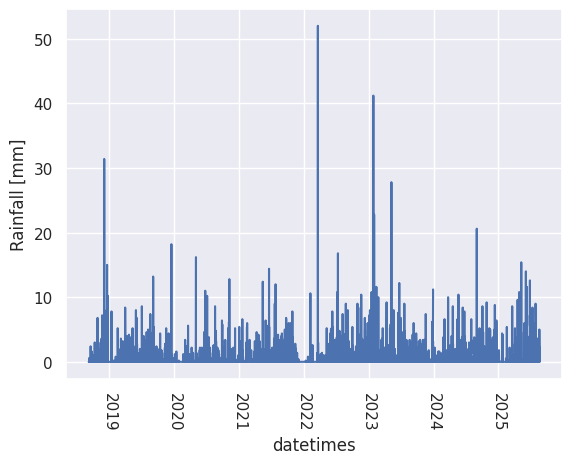

In [5]:
plot_rain_numfeat(train_master, 'datetimes', 'Rainfall [mm]', "line")


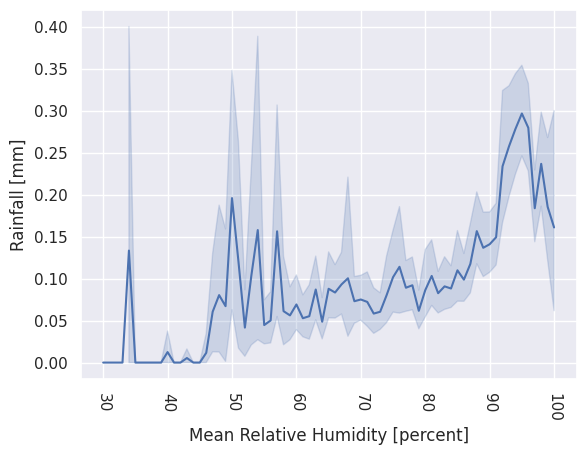

In [6]:
plot_rain_numfeat(train_master, 'Mean Relative Humidity [percent]', 'Rainfall [mm]', "line")


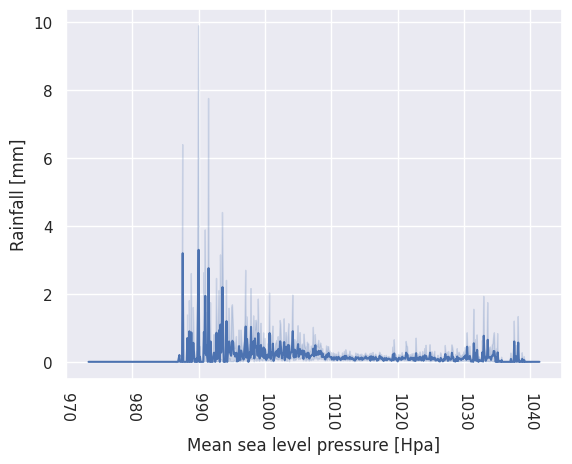

In [7]:
plot_rain_numfeat(train_master,'Mean sea level pressure [Hpa]', 'Rainfall [mm]', "line")


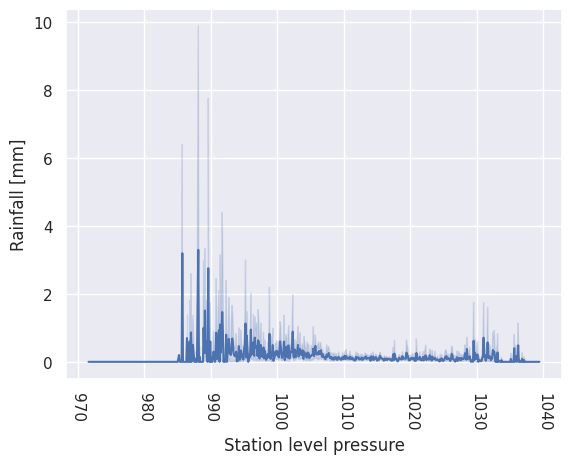

In [8]:
plot_rain_numfeat(train_master,'Station level pressure', 'Rainfall [mm]', "line")


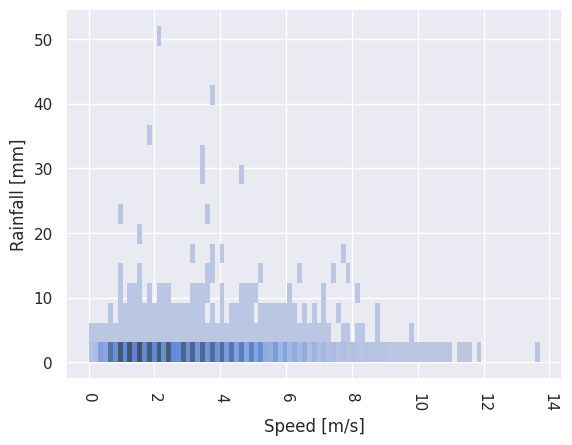

In [9]:
plot_rain_numfeat(train_master,'Speed [m/s]', 'Rainfall [mm]', "hist")


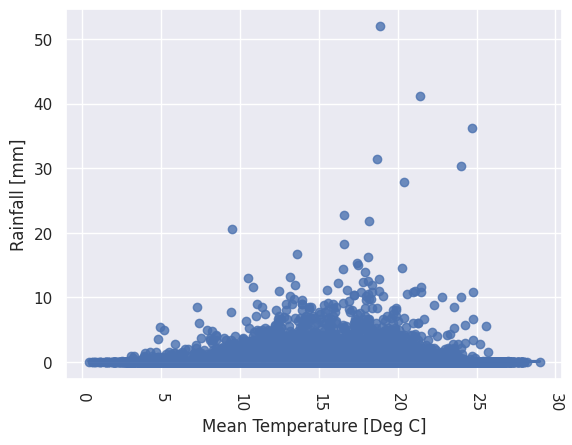

In [10]:
plot_rain_numfeat(train_master, 'Mean Temperature [Deg C]', 'Rainfall [mm]', 'linreg')

Add More Features and Read Neighbouring Station Data
ENSO and wind addition functions remain for posterity

In [11]:
# -------------------- DSIII.V: MAKING NEW FEATURES-------------------- #

def add_cloudiness(df, colname):
    clouds = 1 - np.array(df[colname])
    cloudiness = pd.DataFrame({'cloudiness': clouds}, index=df.index)
    df = pd.concat([df, cloudiness], axis=1)
    return df


def add_seasons(df, colname):
    szn_list = ["Summer" if vals in [12, 1, 2] else
                     "Autumn" if vals in [3,4,5] else
                     "Winter" if vals in [6,7,8] else
                     "Spring" for vals in list(df[colname])]
    szn = pd.DataFrame({'Seasons':szn_list}, index=df.index)
    df = pd.concat([df, szn], axis=1)
    return df


def add_enso(df_include, df_exclude):
    enso = pd.read_csv('ENSO_Oct2018_Aug2025.csv')
    test_data = list(df_exclude.index)
    enso_use = enso.drop(test_data)
    index = list(enso_use['Value'])
    cats = ["La Nina" if p > 0.5 else
            "El Nino" if p < -0.5 else
            "Neutral" for p in index]
    cats_df = pd.DataFrame({"ENSO cat": cats,
                            "ENSO num": enso_use['Value']}, index=df_include.index)
    df_include = pd.concat([df_include, cats_df], axis=1)
    return df_include


def add_dewpoint(df, col1, col2):
    temp = np.array(df[col1])
    rh = np.array(df[col2])
    gamma = np.log(rh/100) + ((17.625*temp)/(243.04 + temp))
    dewpoint = (243.04*gamma)/(17.625 - gamma)
    dp_df = pd.DataFrame({"dewpoint (degC)": dewpoint}, index=df.index)
    df = pd.concat([df, dp_df], axis=1)
    return df


def add_wind_direction(df, exclude, file):
    wind_dir_hrly = pd.read_csv(file)
    wind_dir_hrly['Observation time UTC'] = pd.to_datetime(wind_dir_hrly['Observation time UTC'])
    wind_dir_hrly['YEAR_MONTH'] = wind_dir_hrly['Observation time UTC'].dt.strftime('%Y.%m')
    wind_dir_hrly['u_component'] = np.cos(wind_dir_hrly['Direction [deg T]']*np.pi/180)
    wind_dir_hrly['v_component'] = np.sin(wind_dir_hrly['Direction [deg T]']*np.pi/180)
    drop_index = wind_dir_hrly[wind_dir_hrly['YEAR_MONTH'].astype(float) == 2018.09].index
    wind_dir_hrly.drop(drop_index, inplace=True)
    ym = wind_dir_hrly['YEAR_MONTH'].unique()
    u_months_avg = []
    v_months_avg = []
    for months in ym:
        condition = wind_dir_hrly['YEAR_MONTH'] == months
        u_month = wind_dir_hrly[condition]['u_component']
        u_month_avg = np.sum(u_month)/len(u_month)
        u_months_avg.append(u_month_avg)

    for months in ym:
        condition = wind_dir_hrly['YEAR_MONTH'] == months
        v_month = wind_dir_hrly[condition]['v_component']
        v_month_avg = np.sum(v_month)/len(v_month)
        v_months_avg.append(v_month_avg)

    u_months_avg = np.array(u_months_avg)
    v_months_avg = np.array(v_months_avg)

    test_data = list(exclude.index)
    wind_dir = pd.DataFrame({"wind_direction": (np.degrees(np.arctan2(u_months_avg, v_months_avg))+360) % 360,
                             "Months": ym}, index=data_df.index)
    wind_dir = wind_dir.drop(test_data)
    df = pd.concat([df, wind_dir], axis=1)
    return df


def direction_encoding(df, colname):
    df['wind_sin'] = np.sin(np.deg2rad(df[colname]))
    df['wind_cos'] = np.cos(np.deg2rad(df[colname]))
    return df


def read_extra_rain(data_list, df_to_add):
    for files in data_list:
        file_df = pd.read_csv(files)
        station_name = files.split(".")[0]
        file_df = file_df.rename(columns={'Rainfall [mm]': f'Rainfall_{station_name}'})
        df_to_add = pd.merge(df_to_add, file_df[['Observation time UTC', f'Rainfall_{station_name}']],
            how='left', on='Observation time UTC')

    return df_to_add


def read_extra_wind(data_list, df_to_add):
    for files in data_list:
        file_df = pd.read_csv(files)
        station_name = files.split(".")[0]
        file_df = file_df.rename(columns={'Speed [m/s]':f'Speed_{station_name}'})
        df_to_add = pd.merge(df_to_add, file_df[['Observation time UTC', f'Speed_{station_name}']],
                             how='left', on='Observation time UTC')

    return df_to_add


def read_extra_pressure(data_list, df_to_add):
    for files in data_list:
        file_df = pd.read_csv(files)
        station_name = files.split(".")[0]
        file_df = file_df.rename(columns={'Mean sea level pressure [Hpa]':f'Sea_level_pressure_{station_name}'})
        df_to_add = pd.merge(df_to_add, file_df[['Observation time UTC', f'Sea_level_pressure_{station_name}']],
                             how='left', on='Observation time UTC')

    return df_to_add


train_master = read_extra_rain(['manukau_heads_rain.csv',
                               'motat_rain.csv',
                               'albany_rain.csv'], train_master)


test_master = read_extra_rain(['manukau_heads_rain.csv',
                               'motat_rain.csv',
                               'albany_rain.csv'], test_master)

train_master = read_extra_wind(['manukau_heads_wind.csv',
                                'motat_wind.csv',
                                'albany_wind.csv'], train_master)

test_master = read_extra_wind(['manukau_heads_wind.csv',
                                'motat_wind.csv',
                                'albany_wind.csv'], test_master)

train_master = read_extra_pressure(['manukau_heads_pressure.csv',
                                'motat_pressure.csv',
                                'albany_pressure.csv'], train_master)

test_master = read_extra_pressure(['manukau_heads_pressure.csv',
                                'motat_pressure.csv',
                                'albany_pressure.csv'], test_master)

train_master = add_cloudiness(train_master, 'Sunshine [hrs]')
train_master = add_seasons(train_master, 'months')
train_master = add_dewpoint(train_master, 'Mean Temperature [Deg C]', 'Mean Relative Humidity [percent]')
# train_master = add_enso(train_master, test_master)
# train_master = add_wind_direction(train_master, test_master,'mangere_wind.csv')
train_master = direction_encoding(train_master, 'Direction [deg T]')
train_master.to_csv("train_set_hr.csv")
fpf = os.path.join("/Users/neilkumar/Desktop/Python/Oceanum","train_set_hr.csv" )
if os.path.isfile(fpf):
    pass
else:
    train_master.to_csv("train_set_hr.csv")


test_master = add_cloudiness(test_master, 'Sunshine [hrs]')
test_master = add_seasons(test_master, 'months')
test_master = add_dewpoint(test_master,'Mean Temperature [Deg C]', 'Mean Relative Humidity [percent]')
# test_master = add_enso(test_master, train_master)
# test_master = add_wind_direction(test_master, train_master, 'mangere_wind.csv')
test_master = direction_encoding(test_master, 'Direction [deg T]')
test_master.to_csv("test_set_hr.csv")
fpf = os.path.join("/Users/neilkumar/Desktop/Python/Oceanum","test_set_hr.csv" )
if os.path.isfile(fpf):
    pass
else:
    test_master.to_csv("test_set_hr.csv")


def colormap(df, x, y, s, cmt, c=None, color=False):
    plot_df = pd.DataFrame({s:df[s],
                            x:df[x],
                            y:df[y]})
    plot_df = plot_df.fillna(plot_df[s].mean())
    if c is not None:
        c_plot = df[c]
    else:
        c_plot = None

    if color:
        color_plot = True
    else:
        color_plot = False
    plot_df.plot(kind='scatter',x=x,y=y,alpha=0.5,s=s,
                 c=c_plot,label=s,cmap=plt.get_cmap(cmt),
                 colorbar=color_plot, sharex=False)
    plt.show()


def plot_categorical(df, x, y, type):
    if type.lower() == "box":
        plot = sns.boxplot(data=df,x=x,y=y)
    elif type.lower() == "violin":
        plot = sns.violinplot(data=df, x=x, y=y)
    else:
        plot = sns.swarmplot(data=df,x=x,y=y)
    plot.set_title(y + " vs " + x)
    plt.show()


/tmp/ipython-input-2547755346.py:86: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(files)
/tmp/ipython-input-2547755346.py:86: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(files)


Numerical and Heatmap-Style Plots

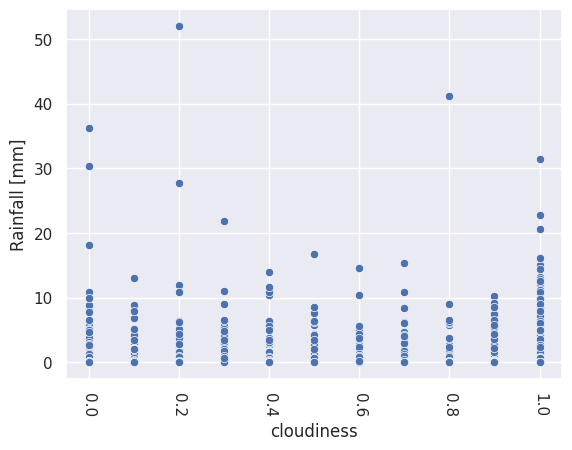

In [13]:
plot_rain_numfeat(train_master, 'cloudiness','Rainfall [mm]',"scatter")


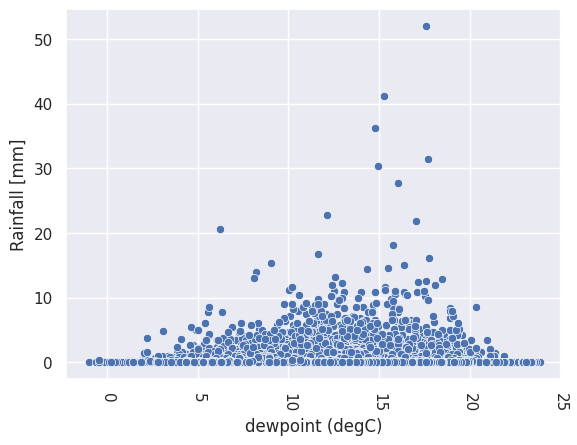

In [14]:
plot_rain_numfeat(train_master, 'dewpoint (degC)','Rainfall [mm]',"scatter")



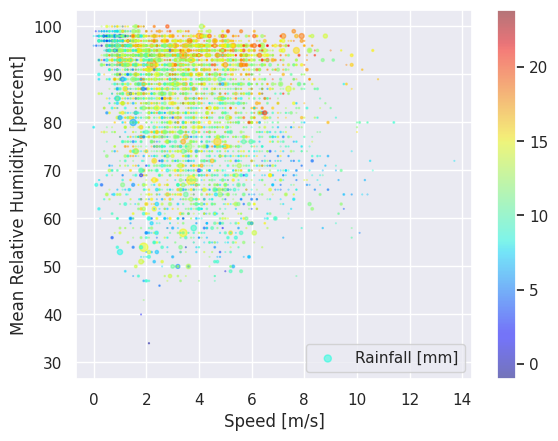

In [15]:
colormap(train_master,'Speed [m/s]', 'Mean Relative Humidity [percent]',
         'Rainfall [mm]',"jet",'dewpoint (degC)',color=True)


/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


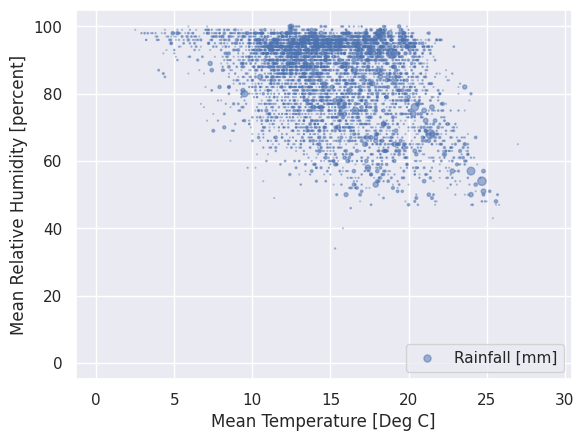

In [17]:
colormap(train_master,'Mean Temperature [Deg C]', 'Mean Relative Humidity [percent]',
         'Rainfall [mm]',"jet", c=None,color=False)


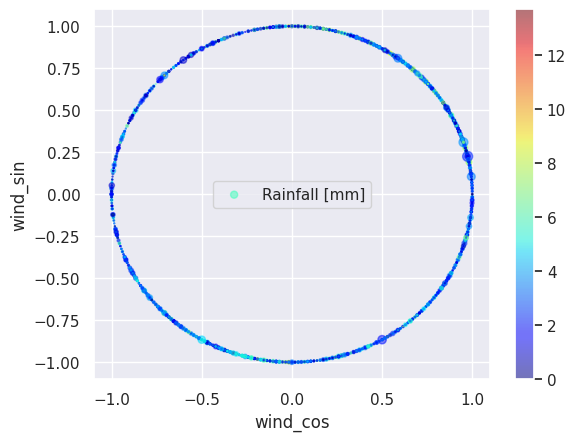

In [18]:
colormap(train_master,'wind_cos', 'wind_sin','Rainfall [mm]',"jet"
         ,'Speed [m/s]',True)

Preprocessing the Data

In [19]:
def split_by_type(train, test):
    train_num = train.select_dtypes(include='number')
    train_cat = train.select_dtypes(exclude='number')
    test_num = test.select_dtypes(include='number')
    test_cat = test.select_dtypes(exclude='number')
    return train_num, train_cat, test_num, test_cat


def lag(train_num, test_num, lags, feats):
    for feat in feats:
        for lag in lags:
            train_num[f'{feat} lag: {str(lag)}'] = train_num[feat].shift(lag)
            test_num[f'{feat} lag: {str(lag)}'] = test_num[feat].shift(lag)
            train_num[f'{feat} lag: {str(lag)}'] = train_num[f'{feat} lag: {str(lag)}'].ffill()
            test_num[f'{feat} lag: {str(lag)}'] = test_num[f'{feat} lag: {str(lag)}'].ffill()
    return train_num, test_num


def rolling_avgs(train_num, test_num, windows, feats):
    for feat in feats:
        for window in windows:
            train_num[f"{window} hr rolling avg {feat}"] = train_num[feat].rolling(window=window, min_periods=1).mean().shift(1)
            test_num[f"{window} hr rolling avg {feat}"] = test_num[feat].rolling(window=window, min_periods=1).mean().shift(1)
            train_num[f"{window} hr rolling avg {feat}"] = train_num[f"{window} hr rolling avg {feat}"].ffill()
            test_num[f"{window} hr rolling avg {feat}"] = test_num[f"{window} hr rolling avg {feat}"].ffill()
    return train_num, test_num


def impute_all(train_num, train_cat, test_num, test_cat):
    from sklearn.impute import SimpleImputer
    num_imp = SimpleImputer(strategy='median')
    cat_imp = SimpleImputer(strategy='most_frequent')
    train_num = pd.DataFrame(num_imp.fit_transform(train_num),columns=train_num.columns,
                             index=train_num.index)
    train_cat = pd.DataFrame(cat_imp.fit_transform(train_cat), columns=train_cat.columns,
                             index=train_cat.index)
    test_num = pd.DataFrame(num_imp.transform(test_num), columns=test_num.columns,
                            index=test_num.index)
    test_cat = pd.DataFrame(cat_imp.transform(test_cat), columns=test_cat.columns,
                            index=test_cat.index)

    return train_num, train_cat, test_num, test_cat


def drop_unwanted(train_num, train_cat, test_num, test_cat, feat_name):
    if feat_name in train_num.columns:
        train_num = train_num.drop(feat_name, axis=1)
    if feat_name in train_cat.columns:
        train_cat = train_cat.drop(feat_name, axis=1)
    if feat_name in test_num.columns:
        test_num = test_num.drop(feat_name, axis=1)
    if feat_name in test_cat.columns:
        test_cat = test_cat.drop(feat_name, axis=1)
    return train_num, train_cat, test_num, test_cat,


def encoding(train_cat, test_cat):
    from sklearn.preprocessing import OneHotEncoder
    ohc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    train_cat = pd.DataFrame(ohc.fit_transform(train_cat),
                             columns=ohc.get_feature_names_out(),index=train_cat.index)
    test_cat = pd.DataFrame(ohc.transform(test_cat),
                            columns=ohc.get_feature_names_out(),index=test_cat.index)
    return train_cat, test_cat


def cyclic_scaling(train_num, test_num, col_name, periods):
    for period in periods:
        train_num[col_name + " sin"] = np.sin(2 * np.pi * train_num[col_name] / period)
        train_num[col_name + " cos"] = np.cos(2 * np.pi * train_num[col_name] / period)
        test_num[col_name + " sin"] = np.sin(2 * np.pi * test_num[col_name] / period)
        test_num[col_name + " cos"] = np.cos(2 * np.pi * test_num[col_name] / period)
    return train_num, test_num


def preshour(train_num, test_num, pressure_list, lag_list):
    i = 0
    for pressures in pressure_list:
        train_num["pressure trend sin"] = (train_num[pressures] - train_num[lag_list[i]])*train_num["hour of day sin"]
        train_num["pressure trend cos"] = (train_num[pressures] - train_num[lag_list[i]])*train_num["hour of day cos"]
        test_num["pressure trend sin"] = (test_num[pressures] - test_num[lag_list[i]])*test_num["hour of day sin"]
        test_num["pressure trend cos"] = (test_num[pressures] - test_num[lag_list[i]])*test_num["hour of day cos"]
        i += 1
    return train_num, test_num


def int_feats(train_num, test_num):
    train_num['dewcloud'] = train_num['dewpoint (degC)']*train_num['cloudiness']
    test_num['dewcloud'] = test_num['dewpoint (degC)'] * test_num['cloudiness']
    train_num['temphum'] = train_num['Mean Temperature [Deg C]']*train_num['Mean Relative Humidity [percent]']
    test_num['temphum'] = test_num['Mean Temperature [Deg C]'] * test_num['Mean Relative Humidity [percent]']
    train_num['dewtemp'] = train_num['dewpoint (degC)']*train_num['Mean Temperature [Deg C]']
    test_num['dewtemp'] = test_num['dewpoint (degC)'] * test_num['Mean Temperature [Deg C]']
    train_num['P_grad_mang_man'] = train_num['Mean sea level pressure [Hpa]'] - train_num['Sea_level_pressure_manukau_heads_pressure']
    train_num['P_grad_mang_motat'] = train_num['Mean sea level pressure [Hpa]'] - train_num['Sea_level_pressure_motat_pressure']
    train_num['P_grad_mang_alb'] = train_num['Mean sea level pressure [Hpa]'] - train_num['Sea_level_pressure_albany_pressure']
    test_num['P_grad_mang_man'] = test_num['Mean sea level pressure [Hpa]'] - test_num['Sea_level_pressure_manukau_heads_pressure']
    test_num['P_grad_mang_motat'] = test_num['Mean sea level pressure [Hpa]'] - test_num['Sea_level_pressure_motat_pressure']
    test_num['P_grad_mang_alb'] = test_num['Mean sea level pressure [Hpa]'] - test_num['Sea_level_pressure_albany_pressure']
    train_num['P_grad_mang_man_t'] = (train_num['Mean sea level pressure [Hpa]'] - train_num['Sea_level_pressure_manukau_heads_pressure'])/6
    train_num['P_grad_mang_motat_t'] = (train_num['Mean sea level pressure [Hpa]'] - train_num['Sea_level_pressure_motat_pressure lag: 6'])/6
    train_num['P_grad_mang_alb_t'] = (train_num['Mean sea level pressure [Hpa]'] - train_num['Sea_level_pressure_albany_pressure lag: 3'])/3
    test_num['P_grad_mang_man_t'] = (test_num['Mean sea level pressure [Hpa]'] - test_num['Sea_level_pressure_manukau_heads_pressure lag: 3'])/3
    test_num['P_grad_mang_motat_t'] = (test_num['Mean sea level pressure [Hpa]'] - test_num['Sea_level_pressure_motat_pressure lag: 6'])/6
    test_num['P_grad_mang_alb_t'] = (test_num['Mean sea level pressure [Hpa]'] - test_num['Sea_level_pressure_albany_pressure lag: 3'])/3
    test_num['dewtemp'] = test_num['dewpoint (degC)'] * test_num['Mean Temperature [Deg C]']
    train_num['suntemp'] = train_num['Sunshine [hrs]'] * train_num['Mean Temperature [Deg C]']
    test_num['suntemp'] = test_num['Sunshine [hrs]'] * test_num['Mean Temperature [Deg C]']
    return train_num, test_num


def variance(train_num,  test_num):
    from sklearn.feature_selection import VarianceThreshold
    low_var_remover = VarianceThreshold()
    train_num = pd.DataFrame(low_var_remover.fit_transform(train_num),
                             columns=train_num.columns, index=train_num.index)
    test_num = pd.DataFrame(low_var_remover.transform(test_num),
                             columns=test_num.columns, index=test_num.index)
    return train_num, test_num


def stdscale(train_num, test_num, feat_list):
    from sklearn.preprocessing import StandardScaler
    train_num_scale = train_num[feat_list]
    test_num_scale = test_num[feat_list]
    scaler = StandardScaler()
    train_num_scale = pd.DataFrame(scaler.fit_transform(train_num_scale),
                                   columns=train_num_scale.columns,
                                   index=train_num_scale.index)
    test_num_scale = pd.DataFrame(scaler.transform(test_num_scale),
                                   columns=test_num_scale.columns,
                                   index=test_num_scale.index)
    train_num.update(train_num_scale)
    test_num.update(test_num_scale)
    return train_num, test_num


feats_to_scale = ["Station level pressure", "Mean sea level pressure [Hpa]", "Sunshine [hrs]", "cloudiness"  ]


def combine(train_num, train_cat, test_num, test_cat):
    train_final = pd.merge(train_num, train_cat, left_index=True, right_index=True)
    test_final = pd.merge(test_num, test_cat, left_index=True, right_index=True)
    return train_final, test_final


def pipeline(train, test, col_name_sc,drop_feat,feat_list, periods, lag_feat, rolling_feat, pressure_list, lag_list):
    train_num, train_cat, test_num, test_cat = split_by_type(train, test)
    train_num, train_cat, test_num, test_cat = drop_unwanted(train_num, train_cat, test_num, test_cat,"Deficit [mm]")
    train_num, train_cat, test_num, test_cat = drop_unwanted(train_num, train_cat, test_num, test_cat,"Runoff [mm]")
    train_num, train_cat, test_num, test_cat = drop_unwanted(train_num, train_cat, test_num, test_cat,"Data source (water balance)")
    train_num, test_num = lag(train_num, test_num, [1,2,3,6,12,24], lag_feat)
    train_num, test_num = rolling_avgs(train_num, test_num, [3,6,12,24], rolling_feat)
    train_num, train_cat, test_num, test_cat = impute_all(train_num, train_cat, test_num, test_cat)
    for unwanted in drop_feat:
        train_num, train_cat, test_num, test_cat = drop_unwanted(train_num, train_cat, test_num, test_cat, unwanted)
    train_cat, test_cat = encoding(train_cat.drop('month names', axis=1), test_cat.drop('month names', axis=1))
    for col in col_name_sc:
        train_num, test_num = cyclic_scaling(train_num, test_num, col, periods)
    train_num, test_num = preshour(train_num, test_num, pressure_list, lag_list)
    train_num, test_num = int_feats(train_num, test_num)
    train_num, test_num = variance(train_num,  test_num)
    train_num, test_num = stdscale(train_num, test_num, feat_list)
    train_num, train_cat, test_num, test_cat = drop_unwanted(train_num, train_cat, test_num, test_cat,"hour of day")
    train_num, train_cat, test_num, test_cat = drop_unwanted(train_num, train_cat, test_num, test_cat,"months")
    train_num, train_cat, test_num, test_cat = drop_unwanted(train_num, train_cat, test_num, test_cat,"days")
    train_num, train_cat, test_num, test_cat = drop_unwanted(train_num, train_cat, test_num, test_cat,"month names")
    train_final, test_final = combine(train_num, train_cat, test_num, test_cat)

    return train_final, test_final


drop_list = ["Frequency [D/H]",
             "Data Source (rainfall)",
             "PERIOD [hrs]",
             "Data Source",
             "Data Source (max temp)",
             "Data Source (min temp)",
             "Grass Temperature [Deg C]",
             "Data Source (grass temp)",
             "Period (max temp)",
             "Period (min temp)",
             "Period (grass temp)",
             "Period (mean temp)",
             "Data Source (mean temp)",
             "Data Source (station level pressure)",
             "Direction [deg T]",
             "Data Source (mean sea level pressure)",
             "datetimes",
             "Deficit [mm]", "Runoff [mm]", "Data source (water balance)",
             "Observation time UTC",
             "Maximum Temperature [Deg C]", "Minimum Temperature [Deg C]", 'years'
             ]

lag_feat = ["Rainfall [mm]", "Mean sea level pressure [Hpa]", "Mean Relative Humidity [percent]",
            "dewpoint (degC)", "wind_sin","wind_cos", "cloudiness", "Sunshine [hrs]",
            "Rainfall_manukau_heads_rain", "Rainfall_motat_rain", "Rainfall_albany_rain",
            "Speed_manukau_heads_wind", "Speed_motat_wind", "Speed_albany_wind",
            "Sea_level_pressure_albany_pressure", "Sea_level_pressure_motat_pressure", "Sea_level_pressure_manukau_heads_pressure"]
roll_feat = lag_feat

pressure_list = ["Sea_level_pressure_albany_pressure", "Sea_level_pressure_motat_pressure"]
lag_list = ["Sea_level_pressure_albany_pressure lag: 6","Sea_level_pressure_motat_pressure lag: 6",
            "Sea_level_pressure_manukau_heads_pressure lag: 6"]

train_master_final, test_master_final = pipeline(train_master, test_master,["months", "days", "hour of day"]
                                                 ,drop_list, feats_to_scale, [12, 365, 24],lag_feat, roll_feat,
                                                 pressure_list, lag_list)
train_master_final.to_csv("feat_eng_df.csv")


/tmp/ipython-input-2296241938.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_num[f'{feat} lag: {str(lag)}'] = train_num[feat].shift(lag)
/tmp/ipython-input-2296241938.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_num[f'{feat} lag: {str(lag)}'] = test_num[feat].shift(lag)
/tmp/ipython-input-2296241938.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

Model Testing with Base Parameters

In [27]:
X_train = train_master_final.drop('Rainfall [mm]', axis=1)
X_test = test_master_final.drop('Rainfall [mm]', axis=1)
y_train = train_master_final['Rainfall [mm]']
y_test = test_master_final['Rainfall [mm]']
y_train_bin = pd.Series(index=y_train.index,data=[1 if i > 0 else 0 for i in list(y_train)])
y_test_bin = pd.Series(index=y_test.index,data=[1 if i > 0 else 0 for i in list(y_test)])



from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

X_train_sub = X_train.sample(n=1000, random_state=42)
y_train_sub = y_train[X_train_sub.index]

X_train.columns = [str(col) for col in X_train.columns]
X_train.columns = X_train.columns.str.replace(r'[\[\]<>]', '', regex=True)



def mae_expm1(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    return mean_absolute_error(y_true, y_pred)


mae_log = make_scorer(mae_expm1, greater_is_better=False)

ridge_score = cross_val_score(Ridge(), X_train_sub, y_train_sub, scoring='neg_mean_absolute_error',cv=10,n_jobs=-1)
print("Ridge Regression avg MAE: ", (-ridge_score).mean())
print("Ridge Regression MAE std: ", (-ridge_score).std(), "\n")

rfr_score = cross_val_score(RandomForestRegressor(n_jobs=-1), X_train_sub, y_train_sub, scoring='neg_mean_absolute_error', cv=10)
print("Random Forest avg MAE: ", (-rfr_score).mean())
print("Random Forest MAE std: ", (-rfr_score).std(), "\n")

X_train_sub.columns = [str(col) for col in X_train_sub.columns]
X_train_sub.columns = X_train_sub.columns.str.replace(r'[\[\]<>]', '', regex=True)

xgb_score = cross_val_score(XGBRegressor(n_jobs=-1, objective='reg:absoluteerror'),
                            X_train_sub, y_train_sub, scoring='neg_mean_absolute_error', n_jobs=-1, cv=10)
print("XGBoost 1st avg MAE: ", (-xgb_score).mean())
print("XGBoost 1st MAE std: ", (-xgb_score).std(), "\n")


svr_score = cross_val_score(SVR(), X_train_sub, y_train_sub,scoring='neg_mean_absolute_error', n_jobs=-1, cv=10)
print("SVR avg MAE: ", (-svr_score).mean())
print("SVR MAE std: ", (-svr_score).std(), "\n")

Ridge Regression avg MAE:  0.22519829162688546
Ridge Regression MAE std:  0.03819001100248526 

Random Forest avg MAE:  0.09141799999999999
Random Forest MAE std:  0.028574512349294777 

XGBoost 1st avg MAE:  0.09854627119487686
XGBoost 1st MAE std:  0.03562703614785613 

SVR avg MAE:  0.18651969795562068
SVR MAE std:  0.04814755699310232 



Split into Classification and Regression Model and optimise (for entire dataset)

In [24]:
prt_fm = train_master_final[train_master_final["Rainfall [mm]"] > 0]
prt_fm = prt_fm.drop("Rainfall [mm]", axis=1)
pure_rain_train = y_train[y_train > 0]   # aka prt
prt_sub = pure_rain_train[prt_fm.index]
prt_fm.columns = [str(col) for col in prt_fm.columns]
prt_fm.columns = prt_fm.columns.str.replace(r'[\[\]<>]', '', regex=True)

train_reg_1 = XGBRegressor(n_estimators=5000, max_depth=4, learning_rate=0.065, verbosity=1,
    objective='reg:absoluteerror', booster='gbtree', tree_method='hist', gamma=8, min_child_weight=0.01, colsample_bytree=0.85,
    reg_lambda=0.05, random_state=42, subsample=0.95,n_jobs=-1)

reg_names = ["control regressor", "test_regressor"]
i = 0
print("target mean:", pure_rain_train.mean())
for regressors in [train_reg_1]:
    prt_sub_score = cross_val_score(regressors, prt_fm, pure_rain_train, cv=10, scoring='neg_mean_absolute_error', n_jobs=-1)
    print(f"{reg_names[i]} avg mae: ", -prt_sub_score.mean())
    print(f"{reg_names[i]} std: ", (-prt_sub_score).std(),"\n")
    i += 1

reg_feats = train_reg_1.fit(prt_fm, pure_rain_train)
reg_imp = pd.DataFrame({"feature_name": reg_feats.feature_names_in_,
                         "feature_importance": reg_feats.feature_importances_}).sort_values(by="feature_importance", ascending=False)
reg_imp.index = [i for i in range(211)]
reg_imp.to_csv("feat_imp_reg_for_dash.csv")

from xgboost import DMatrix, cv, XGBClassifier

scale_pos_weight = (y_train_bin.shape[0] - np.sum(y_train_bin))/np.sum(y_train_bin)

classifier_score = cross_val_score(XGBClassifier(scale_pos_weight=scale_pos_weight,
                                                 n_estimators=190, min_child_weight=0.7,
                                                 max_depth=4,subsample=0.7,
                                                 learning_rate=0.04, gamma=30,
                                                 eval_metric='logloss', colsample_bytree=0.41, random_state=42
                                                 ), X_train, y_train_bin, cv=10,scoring='f1')
print("classification:", classifier_score.mean())

trained_classifier = XGBClassifier(scale_pos_weight=scale_pos_weight,n_estimators=5000, max_depth=4, learning_rate=0.065, verbosity=1,
    objective='reg:absoluteerror', booster='gbtree', tree_method='hist', gamma=8, min_child_weight=0.01, colsample_bytree=0.85,
    reg_lambda=0.05, random_state=42, subsample=0.95,n_jobs=-1)

trained_classifier.fit(X_train, y_train_bin)
class_imp = pd.DataFrame({"feature_name": trained_classifier.feature_names_in_,
                         "feature_importance": trained_classifier.feature_importances_}).sort_values(by="feature_importance", ascending=False)
class_imp.index = [i for i in range(211)]
class_imp.to_csv("feat_imp_class_for_dash.csv")
X_train_class = X_train.drop(list(class_imp["feature_name"])[193:], axis=1)
classifier_score = cross_val_score(XGBClassifier(n_estimators=5000, max_depth=4, learning_rate=0.065, verbosity=1,
    objective='reg:absoluteerror', booster='gbtree', tree_method='hist', gamma=8, min_child_weight=0.01, colsample_bytree=0.85,
    reg_lambda=0.05, random_state=42, subsample=0.95,n_jobs=-1
                                                 ), X_train_class, y_train_bin, cv=10,scoring='f1',n_jobs=-1)
print("classification:", classifier_score.mean())

target mean: 1.2407612031921422
control regressor avg mae:  0.6756200782043946
control regressor std:  0.15972208055771173 

classification: 0.615027048108743


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:02:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


classification: 0.6522991562820888


Final Predictions and Writing of Answers

In [25]:
print("target mean = ", y_train.mean())
whole_class = trained_classifier.fit(X_train_class, y_train_bin)
whole_class_pred = trained_classifier.predict(X_train_class)
whole_reg = train_reg_1.fit(X_train, y_train)
whole_reg_pred = train_reg_1.predict(X_train)
whole_final_pred = whole_class_pred*whole_reg_pred
whole_mae = mean_absolute_error(y_train,whole_final_pred)
print("trainset mae: ", whole_mae)

X_test.columns = [str(col) for col in X_test.columns]
X_test.columns = X_test.columns.str.replace(r'[\[\]<>]', '', regex=True)

oos_class_pred = whole_class.predict(X_test.drop(list(class_imp["feature_name"])[193:], axis=1))
oos_reg_pred = whole_reg.predict(X_test)
final_oos_pred = oos_reg_pred*oos_class_pred
oos_mae = mean_absolute_error(y_test, final_oos_pred)
print("oos mae: ", oos_mae)
print("oos mean: ", y_test.mean())

test_master['classifications'] = list(oos_class_pred)
test_master['regressionss'] = np.maximum(oos_reg_pred, 0)
test_master['final_preds'] = list(final_oos_pred)
test_master.to_csv("csv_mangere_for_dash")


target mean =  0.12609382798203292


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:19:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


trainset mae:  0.07622469390162709
oos mae:  0.08992631302365912
oos mean:  0.1293295624688072
